In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
IMAGE_SIZE = (512, 512)
IMAGE_DIR = Path("/home/anawat/JJ/Chula/Chess2PGN/data")

# Chess board part configs
BILATERAL_FILTER_DIAMETER = 3
BILATERAL_FILTER_SIGMA_COLOR = 75
BILATERAL_FILTER_SIGMA_SPACE = 75

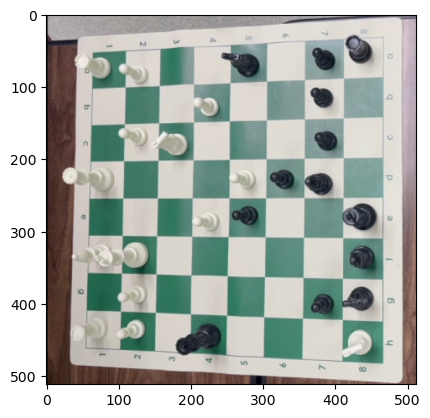

In [3]:
img = cv2.imread(IMAGE_DIR / "test" / "chess3.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)

plt.imshow(img)

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import itertools

def cannyPF(img, sigma=0.25):
  med = np.median(img)
  lower = int(max(0, (1.0 - sigma) * med))
  upper = int(min(255, (1.0 + sigma) * med))
  return cv2.Canny(img, lower, upper)

def group_lines(unique_lines):
  group1, group2 = [], []
  temp_group = []
  group1_mean, group2_mean = None, None

  for i, (rho, theta) in enumerate(unique_lines):
    if group1_mean is None:
      if theta >=np.pi/3 and theta <= 2*np.pi/3:
        group1.append(i)
        group1_mean = theta
      else:
        temp_group.append(i)
    else:
      diff = abs(theta - group1_mean) 
      if diff <= np.pi/3:
        group1.append(i)
        group1_mean = np.mean([unique_lines[j][1] for j in group1])
      else:
        temp_group.append(i)

  for i in temp_group:
    rho, theta = unique_lines[i]
    diff = abs(theta - group1_mean)
    if diff > np.pi/3:
      group2.append(i)
      if group2_mean is None:
        group2_mean = theta
      else:
        group2_mean = np.mean([unique_lines[j][1] for j in group2])
    else:
      group1.append(i)
      group1_mean = np.mean([unique_lines[j][1] for j in group1])
  return group1, group2

def select_best_9_lines(group_indices, unique_lines):
  """Select 9 lines with most uniform spacing"""
  
  # Extract lines and sort by rho (handle negative rho)
  lines_with_idx = [(i, unique_lines[i][0], unique_lines[i][1]) for i in group_indices]
  
  # Normalize: if rho < 0, flip to positive and adjust theta
  normalized = []
  for idx, rho, theta in lines_with_idx:
      if rho < 0:
          rho = -rho
          theta = theta + np.pi if theta < np.pi else theta - np.pi
      normalized.append((idx, rho, theta))
  
  # Sort by rho
  normalized.sort(key=lambda x: x[1])
  sorted_indices = [x[0] for x in normalized]
  sorted_rhos = [x[1] for x in normalized]
  
  if len(sorted_indices) <= 9:
      return sorted_indices
  
  # Try all combinations
  best_indices = None
  best_score = float('inf')
  
  for combo in itertools.combinations(range(len(sorted_indices)), 9):
      combo_rhos = [sorted_rhos[i] for i in combo]
      
      # Linear fit
      x = np.arange(9)
      poly_coeffs = np.polyfit(x, combo_rhos, deg=2)
      predicted = np.polyval(poly_coeffs, x)
      mse = np.mean((combo_rhos - predicted) ** 2)
      
      if mse < best_score:
          best_score = mse
          best_indices = [sorted_indices[i] for i in combo]
  
  return best_indices

def get_line_intersections(lines_group1, lines_group2, unique_lines, img_shape):
    """Calculate intersection points between two groups of lines"""
    intersections = []
    
    for i in lines_group1:
        rho1, theta1 = unique_lines[i]
        for j in lines_group2:
            rho2, theta2 = unique_lines[j]
            
            cos1, sin1 = np.cos(theta1), np.sin(theta1)
            cos2, sin2 = np.cos(theta2), np.sin(theta2)
            
            det = cos1 * sin2 - sin1 * cos2
            
            if abs(det) > 1e-6:  # Lines not parallel
                x = (rho1 * sin2 - rho2 * sin1) / det
                y = (rho2 * cos1 - rho1 * cos2) / det
                
                # Check if intersection is within image bounds
                if 0 <= x < img_shape[1] and 0 <= y < img_shape[0]:
                    intersections.append((x, y))
    
    return intersections

def create_chess_grid(lines_group1, lines_group2, unique_lines, img_shape):
    """Create 8x8 chess grid from 9x9 line intersections"""
    
    # Sort lines by rho to get consistent ordering
    def get_sorted_lines(group_indices):
        lines_data = []
        for i in group_indices:
            rho, theta = unique_lines[i]
            if rho < 0:
                rho = -rho
                theta = theta + np.pi if theta < np.pi else theta - np.pi
            lines_data.append((i, rho, theta))
        lines_data.sort(key=lambda x: x[1])
        return [x[0] for x in lines_data]
    
    sorted_group1 = get_sorted_lines(lines_group1)
    sorted_group2 = get_sorted_lines(lines_group2)
    
    # Calculate all intersection points in order
    grid_points = np.zeros((9, 9, 2))
    
    for i, idx1 in enumerate(sorted_group1):
        for j, idx2 in enumerate(sorted_group2):
            rho1, theta1 = unique_lines[idx1]
            rho2, theta2 = unique_lines[idx2]
            
            cos1, sin1 = np.cos(theta1), np.sin(theta1)
            cos2, sin2 = np.cos(theta2), np.sin(theta2)
            
            det = cos1 * sin2 - sin1 * cos2
            
            if abs(det) > 1e-6:
                x = (rho1 * sin2 - rho2 * sin1) / det
                y = (rho2 * cos1 - rho1 * cos2) / det
                grid_points[i, j] = [x, y]
    
    return grid_points, sorted_group1, sorted_group2

def get_cell_centers(grid_points):
    """Calculate center points of 64 chess squares"""
    cell_centers = {}
    files = 'hgfedcba'
    ranks = '12345678'  # Top to bottom in image
    
    for row in range(8):
        for col in range(8):
            # Get 4 corners of the cell
            tl = grid_points[row, col]
            tr = grid_points[row, col + 1]
            bl = grid_points[row + 1, col]
            br = grid_points[row + 1, col + 1]
            
            # Calculate center
            center_x = (tl[0] + tr[0] + bl[0] + br[0]) / 4
            center_y = (tl[1] + tr[1] + bl[1] + br[1]) / 4
            
            # Map to chess notation
            square = files[col] + ranks[row]
            cell_centers[square] = {
                'center': (center_x, center_y),
                'corners': [tl, tr, br, bl]  # clockwise from top-left
            }
    
    return cell_centers

def point_in_cell(point, cell_data):
    """Check if a point is inside a cell using its corners"""
    px, py = point
    corners = cell_data['corners']
    
    # Use simple bounding box check (can be improved with polygon test)
    xs = [c[0] for c in corners]
    ys = [c[1] for c in corners]
    
    return min(xs) <= px <= max(xs) and min(ys) <= py <= max(ys)

def find_representative_lines(img):
  # Detect lines and find representative lines
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  bilateral = cv2.bilateralFilter(gray, d=(BILATERAL_FILTER_DIAMETER), sigmaColor=75, sigmaSpace=75)
  canny = cannyPF(bilateral, sigma=0.33)
  lines = cv2.HoughLines(canny, 1, np.pi/720.0, 50, np.array([]), 0, 0)
  lines_best = np.squeeze(lines)[:100]

  scaler = StandardScaler()
  lines_normalized = scaler.fit_transform(lines_best)
  clustering = DBSCAN(eps=0.05, min_samples=2).fit(lines_normalized)
  labels = clustering.labels_

  unique_lines = []
  for label in set(labels):
    if label != -1:  # Not noise
      cluster_lines = lines_best[labels == label]
      avg_rho = np.mean(cluster_lines[:, 0])
      avg_theta = np.mean(cluster_lines[:, 1])
      unique_lines.append([avg_rho, avg_theta])

  group1, group2 = group_lines(unique_lines)

  best_group1 = select_best_9_lines(group1, unique_lines)
  best_group2 = select_best_9_lines(group2, unique_lines)

  return best_group1, best_group2, unique_lines

def get_chess_grid(img, visualize=False):
  best_group1, best_group2, unique_lines = find_representative_lines(img)
  grid_points, sorted_g1, sorted_g2 = create_chess_grid(
      best_group1, best_group2, unique_lines, img.shape
  )
  cell_centers = get_cell_centers(grid_points)

  if visualize:
    # Visualize grid
    canvas = img.copy()

    # Draw grid lines
    for i in sorted_g1:
        rho, theta = unique_lines[i]
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * a)
        x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * a)
        cv2.line(canvas, (x1, y1), (x2, y2), (0, 255, 0), 1)

    for i in sorted_g2:
        rho, theta = unique_lines[i]
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * a)
        x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * a)
        cv2.line(canvas, (x1, y1), (x2, y2), (0, 0, 255), 1)

    # Draw cell centers and labels
    for square, cell_data in cell_centers.items():
        cx, cy = cell_data['center']
        cv2.circle(canvas, (int(cx), int(cy)), 3, (255, 0, 255), -1)
        cv2.putText(canvas, square, (int(cx)-10, int(cy)+5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(canvas)
    plt.title('Chess Grid with Square Labels')
    plt.show()

    print(f"\nGrid created with {len(cell_centers)} squares")
    print("\nSample cell centers:")
    for square in ['a8', 'a1', 'h8', 'h1']:
        center = cell_centers[square]['center']
        print(f"  {square}: ({center[0]:.1f}, {center[1]:.1f})")

  return cell_centers, unique_lines

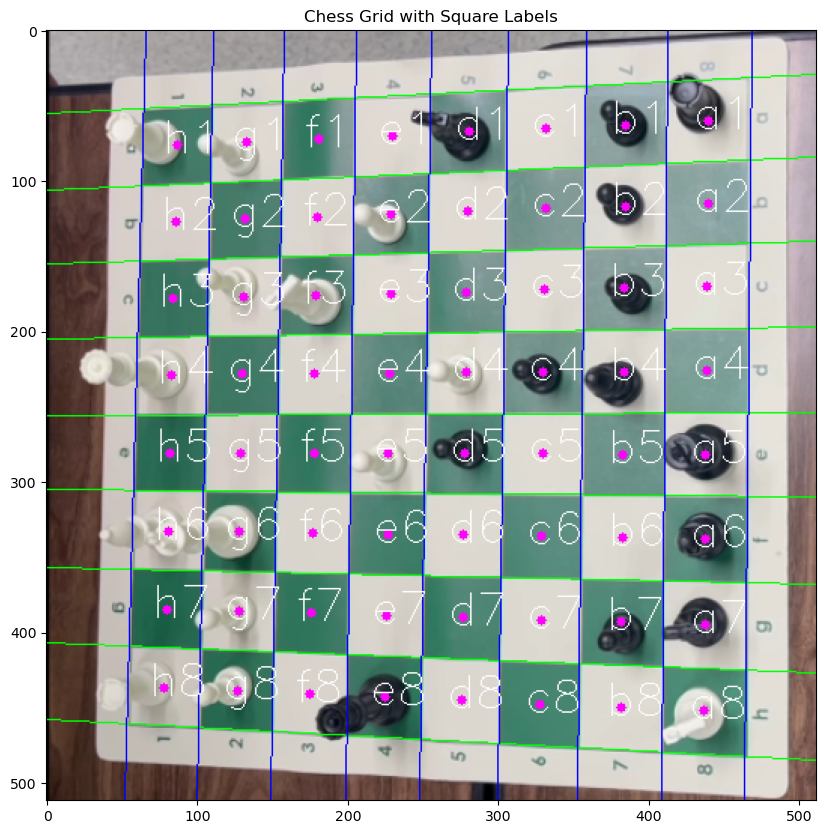


Grid created with 64 squares

Sample cell centers:
  a8: (437.8, 453.0)
  a1: (440.5, 60.7)
  h8: (78.9, 437.0)
  h1: (87.2, 76.5)


In [5]:
cell_centers, unique_lines = get_chess_grid(img, visualize=True)

In [6]:
def map_pieces_to_grid(yolo_results, cell_centers, weight_bottom=0.7):
    """
    Map detected pieces to chess squares using weighted average of bbox center and bottom-center
    
    Args:
        yolo_results: YOLO detection results
        cell_centers: Dictionary of chess square centers
        weight_bottom: Weight for bottom-center (default 0.7), remaining weight goes to bbox center
    """
    board = {square: None for square in cell_centers.keys()}
    
    for box in yolo_results[0].boxes:
        # Get bounding box info
        x_center = float(box.xywh[0][0])
        y_center = float(box.xywh[0][1])
        width = float(box.xywh[0][2])
        height = float(box.xywh[0][3])
        
        # Calculate BOTTOM CENTER of bounding box (where piece actually sits)
        x_bottom_center = x_center
        y_bottom_center = y_center + (height / 2)
        
        # Calculate WEIGHTED AVERAGE of center and bottom-center
        weight_center = 1.0 - weight_bottom
        x_weighted = weight_bottom * x_bottom_center + weight_center * x_center
        y_weighted = weight_bottom * y_bottom_center + weight_center * y_center
        
        class_id = int(box.cls[0])
        class_name = yolo_results[0].names[class_id]
        confidence = float(box.conf[0])
        
        # Find which square contains this piece using weighted position
        for square, cell_data in cell_centers.items():
            if point_in_cell((x_weighted, y_weighted), cell_data):
                # Handle multiple detections: keep highest confidence
                if board[square] is not None:
                    print(f"Square {square} already has {board[square]['piece']} with confidence {board[square]['confidence']:.2f}. New piece: {class_name} with confidence {confidence:.2f}")
                if board[square] is None or confidence > board[square]['confidence']:
                    board[square] = {
                        'piece': class_name,
                        'confidence': confidence,
                        'position': (x_weighted, y_weighted),  # Store weighted position
                        'bbox_center': (x_center, y_center),  # Keep for visualization
                        'bottom_center': (x_bottom_center, y_bottom_center)  # Keep for debugging
                    }
                break
    
    return board

In [7]:
def detect_orientation_by_piece_clustering(board_state, img_shape):
    """
    Detect board orientation by analyzing where white pieces cluster
    White pieces should be at the TOP in standard orientation
    Returns: rotation angle in degrees (0, 90, 180, 270)
    """
    white_pieces = []
    black_pieces = []
    
    # Collect piece positions
    for square, piece_data in board_state.items():
        if piece_data is not None:
            piece_name = piece_data['piece']
            x, y = piece_data['position']
            
            if piece_name[0].lower() == 'w':
                white_pieces.append({'square': square, 'x': x, 'y': y})
            else:
                black_pieces.append({'square': square, 'x': x, 'y': y})
    
    if len(white_pieces) < 2 or len(black_pieces) < 2:
        print("Not enough pieces detected for orientation")
        return 0
    
    # Calculate center of mass for each color
    white_center_y = np.mean([p['y'] for p in white_pieces])
    black_center_y = np.mean([p['y'] for p in black_pieces])
    white_center_x = np.mean([p['x'] for p in white_pieces])
    black_center_x = np.mean([p['x'] for p in black_pieces])
    
    img_height, img_width = img_shape[:2]
    
    # Determine orientation based on piece clustering
    # Calculate which edge white pieces are closest to
    dist_to_top = white_center_y
    dist_to_bottom = img_height - white_center_y
    dist_to_left = white_center_x
    dist_to_right = img_width - white_center_x
    
    edges = {
        'top': dist_to_top,
        'bottom': dist_to_bottom,
        'left': dist_to_left,
        'right': dist_to_right
    }
    
    closest_edge = min(edges, key=edges.get)
    
    # Map edge to rotation (white should be at TOP)
    rotation_map = {
        'top': 0,       # Standard: white at top
        'bottom': 180,  # Inverted: white at bottom
        'right': 90,    # Rotated: white on right
        'left': 270     # Rotated: white on left
    }
    
    rotation = rotation_map[closest_edge]
    
    print(f"White pieces center: ({white_center_x:.1f}, {white_center_y:.1f})")
    print(f"Black pieces center: ({black_center_x:.1f}, {black_center_y:.1f})")
    print(f"Closest edge for white: {closest_edge}")
    print(f"Detected rotation: {rotation}°")
    
    return rotation

In [8]:
from ultralytics import YOLO

model = YOLO("/home/anawat/JJ/Chula/Chess2PGN/weights/chess-piece/best(4).pt")

In [9]:
results = model(img)

board_state = map_pieces_to_grid(results, cell_centers)

print("Detecting board orientation...")
rotation_angle = detect_orientation_by_piece_clustering(board_state, img.shape)


0: 640x640 2 black-bishops, 2 black-knights, 6 black-pawns, 1 black-queen, 1 white-king, 2 white-knights, 8 white-pawns, 1 white-queen, 2 white-rooks, 428.9ms
Speed: 3.0ms preprocess, 428.9ms inference, 15.1ms postprocess per image at shape (1, 3, 640, 640)
Square b1 already has black-pawn with confidence 0.73. New piece: white-pawn with confidence 0.38
Detecting board orientation...
White pieces center: (167.3, 278.7)
Black pieces center: (351.3, 262.6)
Closest edge for white: left
Detected rotation: 270°



Rotating image by 270° to normalize orientation...
Image normalized. Now detecting pieces on normalized image...



0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 6 black-pawns, 1 black-queen, 2 black-rooks, 1 white-bishop, 1 white-king, 3 white-knights, 7 white-pawns, 1 white-queen, 2 white-rooks, 525.8ms
Speed: 5.0ms preprocess, 525.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)
Detected 29 pieces on normalized image


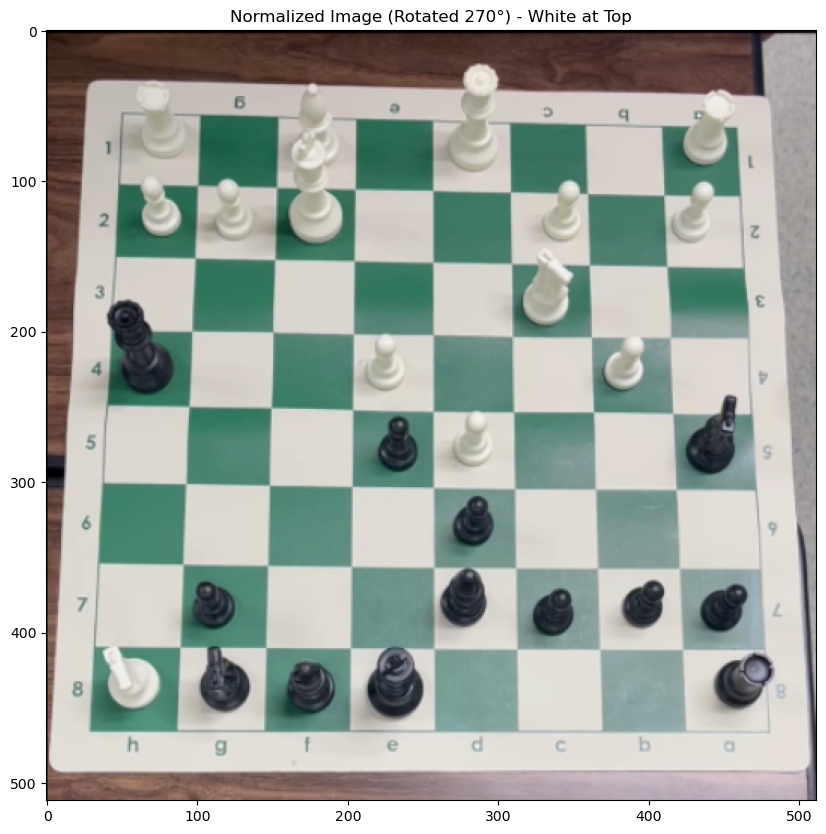

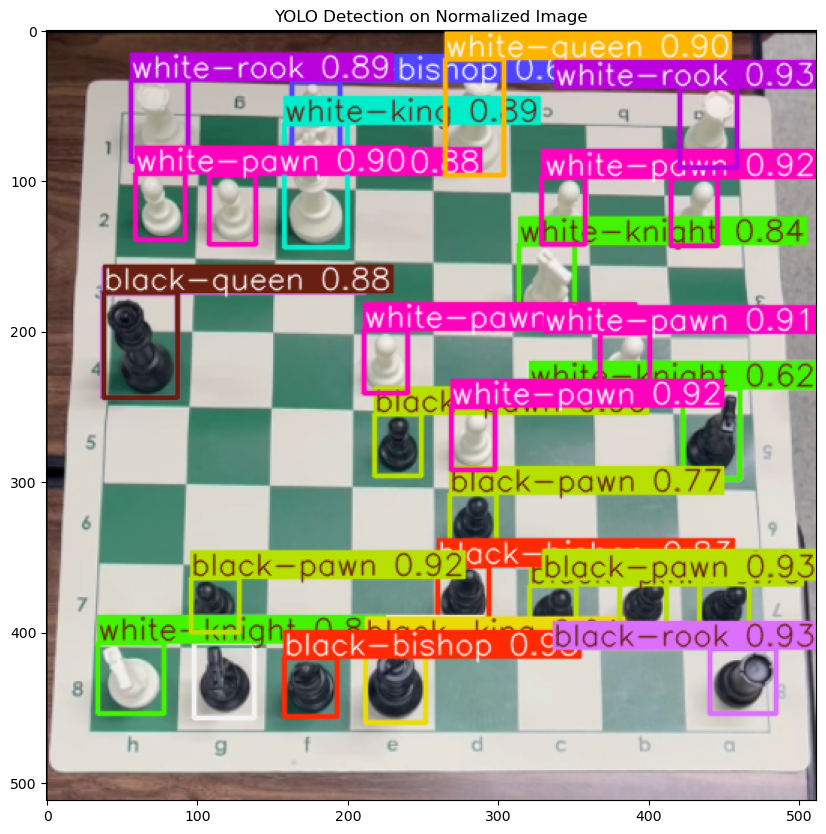

In [10]:
# Rotate image to standard orientation (white at top)
print(f"\nRotating image by {rotation_angle}° to normalize orientation...")
h, w = img.shape[:2]
center = (w // 2, h // 2)
rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

# Calculate new image dimensions
if rotation_angle in [90, 270]:
    new_w, new_h = h, w
else:
    new_w, new_h = w, h

# Adjust rotation matrix for new dimensions
rotation_matrix[0, 2] += (new_w - w) / 2
rotation_matrix[1, 2] += (new_h - h) / 2

# Rotate image
normalized_img = cv2.warpAffine(img, rotation_matrix, (new_w, new_h))

print("Image normalized. Now detecting pieces on normalized image...")

# Run YOLO again on normalized image
results_normalized = model(normalized_img)

print(f"Detected {len(results_normalized[0].boxes)} pieces on normalized image")

# Visualize normalized detection
plt.figure(figsize=(10, 10))
plt.imshow(normalized_img)
plt.title(f'Normalized Image (Rotated {rotation_angle}°) - White at Top')
plt.show()

# Show YOLO detection on normalized image
annotated = results_normalized[0].plot()
plt.figure(figsize=(10, 10))
plt.imshow(annotated)
plt.title('YOLO Detection on Normalized Image')
plt.show()